In [15]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
import pickle
from sklearn import preprocessing
from sklearn import svm
import pandas as pd
from scipy.stats import kendalltau
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.inspection import permutation_importance
from scipy.cluster import hierarchy
from scipy.stats import spearmanr
from collections import defaultdict
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
import time

In [2]:
X_train, y_train, X_test, y_test = pickle.load(open('Data/adult_income/processed_data.pkl', 'rb'))

# Ensembles

### Random Forest

In [13]:
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced')
rf_model.fit(X_train, y_train)
all_rf_accuracies = []
all_rf_predictions = []

for estimator in rf_model.estimators_:
    predictions = estimator.predict(X_test)
    accuracy = accuracy_score(y_test,predictions)
    all_rf_accuracies.append(accuracy)
#     prec = precision_score(y_test,predictions)
#     roc_auc = roc_auc_score(y_test,predictions)
    all_rf_predictions.append(predictions)

agg_predictions = rf_model.predict(X_test)
print("Overall accuracy: {0}, individual average accuracy: {1}".format(accuracy_score(y_test, agg_predictions), np.mean(all_rf_accuracies)))

Overall accuracy: 0.8472775564409031, individual average accuracy: 0.7997310756972112


In [ ]:
# # all separate trees

# all_predictions = []
# for rs in range(30):
#     np.random.seed(rs)
    
#     # bootstrapping
#     samples = np.random.choice(np.arange(len(X_train)), len(X_train))
#     X_train_this, y_train_this = X_train.iloc[samples], y_train.iloc[samples]
    
# #     model = svm.SVC(class_weight='balanced', random_state=rs)
#     model = RandomForestClassifier(n_estimators=1, class_weight='balanced', random_state=rs)
#     model.fit(X_train_this, y_train_this)
#     predictions = model.predict(X_test)
#     accuracy = accuracy_score(y_test,predictions)
#     prec = precision_score(y_test,predictions)
#     roc_auc = roc_auc_score(y_test,predictions)
#     all_predictions.append(predictions)
# #     print("Accuracy: {0}, Precision: {1}, ROC AUC: {2}".format(accuracy, prec, roc_auc))

### Bagging Ensemble of MLP's

In [11]:
start = time.time()
model = BaggingClassifier(base_estimator=MLPClassifier(max_iter=300), n_estimators=10)
model.fit(X_train, y_train)
all_accuracies = []
all_predictions = []

for estimator in model.estimators_:
    predictions = estimator.predict(X_test)
    accuracy = accuracy_score(y_test,predictions)
    all_accuracies.append(accuracy)
    all_predictions.append(predictions)

print("Took {} minutes".format((time.time() - start) // 60))
agg_predictions = model.predict(X_test)
print("Overall accuracy: {0}, individual average accuracy: {1}".format(accuracy_score(y_test, agg_predictions), np.mean(all_accuracies)))


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: C

Took 4.0 minutes
Overall accuracy: 0.8408366533864542, individual average accuracy: 0.8306706507304117


# Investigating what is a shared trait amongst those most likely to be wrong

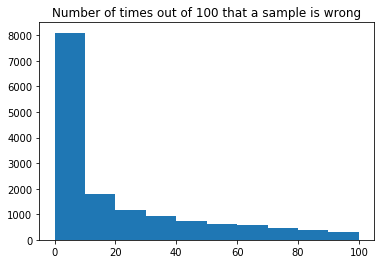

In [16]:
num_rf_wrongs = np.zeros(len(y_test))
for predictions in all_rf_predictions:
    wrongs = np.array(y_test!=predictions)
    num_rf_wrongs += wrongs

plt.hist(num_rf_wrongs)
plt.title('Number of times out of {} that a sample is wrong'.format(len(all_rf_predictions)))
plt.show()

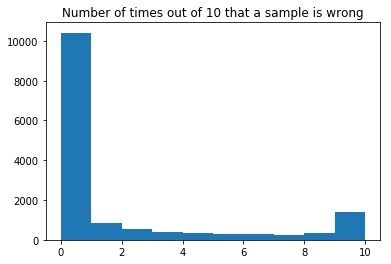

In [17]:
num_wrongs = np.zeros(len(y_test))
for predictions in all_predictions:
    wrongs = np.array(y_test!=predictions)
    num_wrongs += wrongs

plt.hist(num_wrongs)
plt.title('Number of times out of {} that a sample is wrong'.format(len(all_predictions)))
plt.show()

In [18]:
kendalltau(np.argsort(num_wrongs), np.argsort(num_rf_wrongs))

KendalltauResult(correlation=-0.008397937567744825, pvalue=0.12217642118216845)

In [ ]:
dists = []
sorted_mlp = list(np.argsort(num_wrongs))
sorted_rf = list(np.argsort(num_rf_wrongs))
for i in range(len(num_wrongs)):
    dists.append(sorted_mlp.index(i) - sorted_rf.index(i))
dists = np.absolute(dists)

(array([5831., 3180., 1914., 1742., 1129.,  764.,  341.,  110.,   41.,
           8.]),
 array([0.        , 0.09575033, 0.19150066, 0.287251  , 0.38300133,
        0.47875166, 0.57450199, 0.67025232, 0.76600266, 0.86175299,
        0.95750332]),
 <a list of 10 Patch objects>)

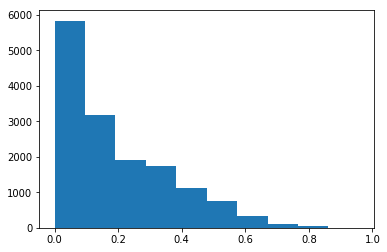

In [25]:
dists = np.array(dists) / len(num_wrongs)
plt.hist(dists)

R^2 score: 0.18549567325069882


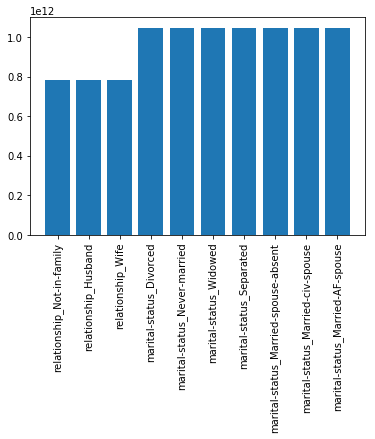

In [26]:
model = LinearRegression()
model.fit(X_test, num_wrongs)
importance = model.coef_
print("R^2 score: {}".format(model.score(X_test, num_wrongs)))

most_important = np.argsort(np.absolute(importance))[-10:]
plt.bar(np.array(X_train.keys())[most_important], np.array(importance)[most_important])
plt.xticks(rotation='vertical')
plt.show()

R^2 score: 0.32479214375037746


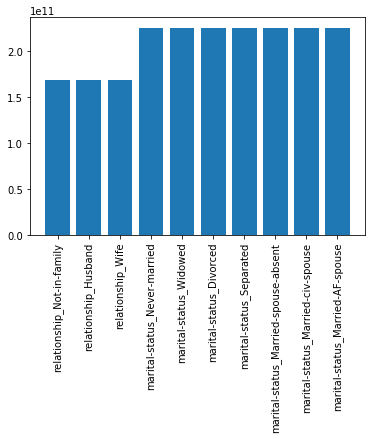

In [27]:
model = LinearRegression()
model.fit(X_test, num_rf_wrongs)
importance = model.coef_
print("R^2 score: {}".format(model.score(X_test, num_rf_wrongs)))

most_important = np.argsort(np.absolute(importance))[-10:]
plt.bar(np.array(X_train.keys())[most_important], np.array(importance)[most_important])
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
model = svm.SVR()

model.fit(X_test, num_wrongs)
print("R^2 score: {}".format(model.score(X_test, num_wrongs)))

importance = permutation_importance(model, X_test, num_wrongs).importances_mean

most_important = np.argsort(np.absolute(importance))[-10:]
plt.bar(np.array(X_train.keys())[most_important], np.array(importance)[most_important])
plt.xticks(rotation='vertical')
plt.show()

## Getting rid of collinear features

In [30]:
corr = spearmanr(X_train).correlation
corr_linkage = hierarchy.ward(corr)
cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
# selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

selected_features = []
for v in cluster_id_to_feature_ids.values():
    if len(v) > 1:
        print("Retained only one of {}".format([list(X_train.keys())[ind] for ind in v]))
    selected_features.append(v[0])

X_train_sel = X_train.iloc[:, selected_features]
X_test_sel = X_test.iloc[:, selected_features]

clf_sel = RandomForestClassifier()
clf_sel.fit(X_train_sel, y_train)
print("Accuracy on test data with features removed: {:.2f}".format(
      clf_sel.score(X_test_sel, y_test)))

Retained only one of ['marital-status_Married-civ-spouse', 'relationship_Husband']
Accuracy on test data with features removed: 0.85
